In [1]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, wilcoxon

import matplotlib.pylab as plt
    
from matplotlib.patches import Rectangle

from collections import Counter

In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon


def run_wilcoxon_barplots(
    joined_df: pd.DataFrame,
    cols_: list,
    asistencia_col: str = "Asitencia_new",
    asistencia_min: int = 3,
    count_threshold: int = 3,
    outlier_totalcount_thr: int = 25,
    split_at: int = 20,
    special_reverse_cols: tuple = ("veces consume comida no saludable", "veces consume sustancia toxica"),
    pdf_path_part1 = None,
    pdf_path_part2 = None,
    figsize=(10.5, 10.5),
    nrows: int = 5,
    ncols: int = 4,
    palette=("lightcoral", "coral"),
    show: bool = True,
):


    warnings.filterwarnings("ignore")

    df = joined_df.copy()

    if asistencia_col in df.columns:
        df = df[df[asistencia_col] >= asistencia_min].copy()

    for col in cols_:
        xcol = col + "_x"
        if xcol in df.columns:
            df[f"{col}_count"] = (df[xcol] >= count_threshold).astype(int)
        else:
            df[f"{col}_count"] = np.nan  # por si falta la columna

    count_cols = [f"{col}_count" for col in cols_]
    df["total_count"] = df[count_cols].sum(axis=1)

    indx_for_erase = list(df[df["total_count"] > outlier_totalcount_thr].index)
    df = df.drop(index=indx_for_erase).copy()

    def _plot_block(cols_block, pdf_path=None, block_name=""):
        results = []

        fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
        axes = axes.flatten()

        for idx, col in enumerate(cols_block):
            if idx >= len(axes):
                break  

            xcol = col + "_x"
            ycol = col + "_y"
            if (xcol not in df.columns) or (ycol not in df.columns):
                axes[idx].set_visible(False)
                continue

            current_joint = df.dropna(subset=[xcol, ycol]).copy()
            if len(current_joint) <= 1:
                axes[idx].set_visible(False)
                continue

            pre_ = current_joint[[xcol]]
            post_ = current_joint[[ycol]]

            paired_data = pd.DataFrame({
                "Condition": (["Pre"] * len(pre_)) + (["Post2"] * len(post_)),
                "Value": list(pre_[xcol]) + list(post_[ycol])
            })

            paired_data_wide = pd.DataFrame({"Pre": pre_[xcol], "Post2": post_[ycol]})

            try:
                if col in special_reverse_cols:
                    test_result = wilcoxon(current_joint[xcol], current_joint[ycol], alternative="greater")
                else:
                    test_result = wilcoxon(current_joint[ycol], current_joint[xcol], alternative="greater")

                results.append((col, float(test_result.statistic), float(test_result.pvalue)))

                sns.barplot(
                    data=paired_data,
                    x="Condition",
                    y="Value",
                    ax=axes[idx],
                    errorbar=("ci", 95),
                    palette=list(palette),
                    hue="Condition",
                )

                axes[idx].set_title(
                    f"{col}\nW = {test_result.statistic:.2f}, p = {test_result.pvalue:.4f}\n"
                    f"n = {paired_data_wide.shape[0]:.0f}",
                    fontsize=10
                )
                axes[idx].set_ylabel("Mean ± 95% CI", fontsize=8)
                axes[idx].set_xlabel("", fontsize=8)

            except Exception:
                axes[idx].set_visible(False)
                continue

        plt.tight_layout()

        if pdf_path is not None:
            fig.savefig(pdf_path, format="pdf", bbox_inches="tight")

        if show:
            plt.show()
        else:
            plt.close(fig)

        results_df = pd.DataFrame(results, columns=["Column", "W", "pvalue"])
        return results_df

    # 4) Partes
    cols_part1 = cols_[:split_at]
    cols_part2 = cols_[split_at:]

    res1 = _plot_block(cols_part1, pdf_path=pdf_path_part1, block_name="part1")
    res2 = _plot_block(cols_part2, pdf_path=pdf_path_part2, block_name="part2")

    return {
        "joined_df_filtered": df,
        "removed_outlier_indices": indx_for_erase,
        "results_part1": res1,
        "results_part2": res2,
    }




## Load data

In [3]:
df_data = pd.read_excel("../Data/data.xlsx")

In [4]:
cols_ = ['ayudo desarrollo act otros',
       'comparto con amigos y conoc', 'intenta ayudar',
       'voluntario favor necesitados',
       'acude inmediat. necesitados', 'manos a la obra encuentra dificul.',
       'comparto intens emoc. demás', 'conoc. y cap. a disp. otros',
       'intenta consolar pers. triste', 'presta dine. expont.',
       'facil ponerse en lugar de disgust.', 'cerca y cuidar pers. necesita',
       'comparte buens oport.', 'hace compañía conoc. sienten solos',
       'instuye malestar otros', 'veces hace ejerci. no escuela',
       'usa bici. o camina para movil', 'veces come verd. y frutas',
       'veces consume carne', 'veces consume arroz o fideo',
       'veces consume comida no saludable', 'veces consume sustancia toxica',
       'veces habla sobre clima', 'veces junta amigos',
       'veces particip. actividad grupal', 'noches calidad de sueño buena',
       'actividades nuevo aprendizaje', 'veces actividades esfuerzo mental',
       'horas duerme por noche',
       'cada cuanto va al med. para controles de salud']

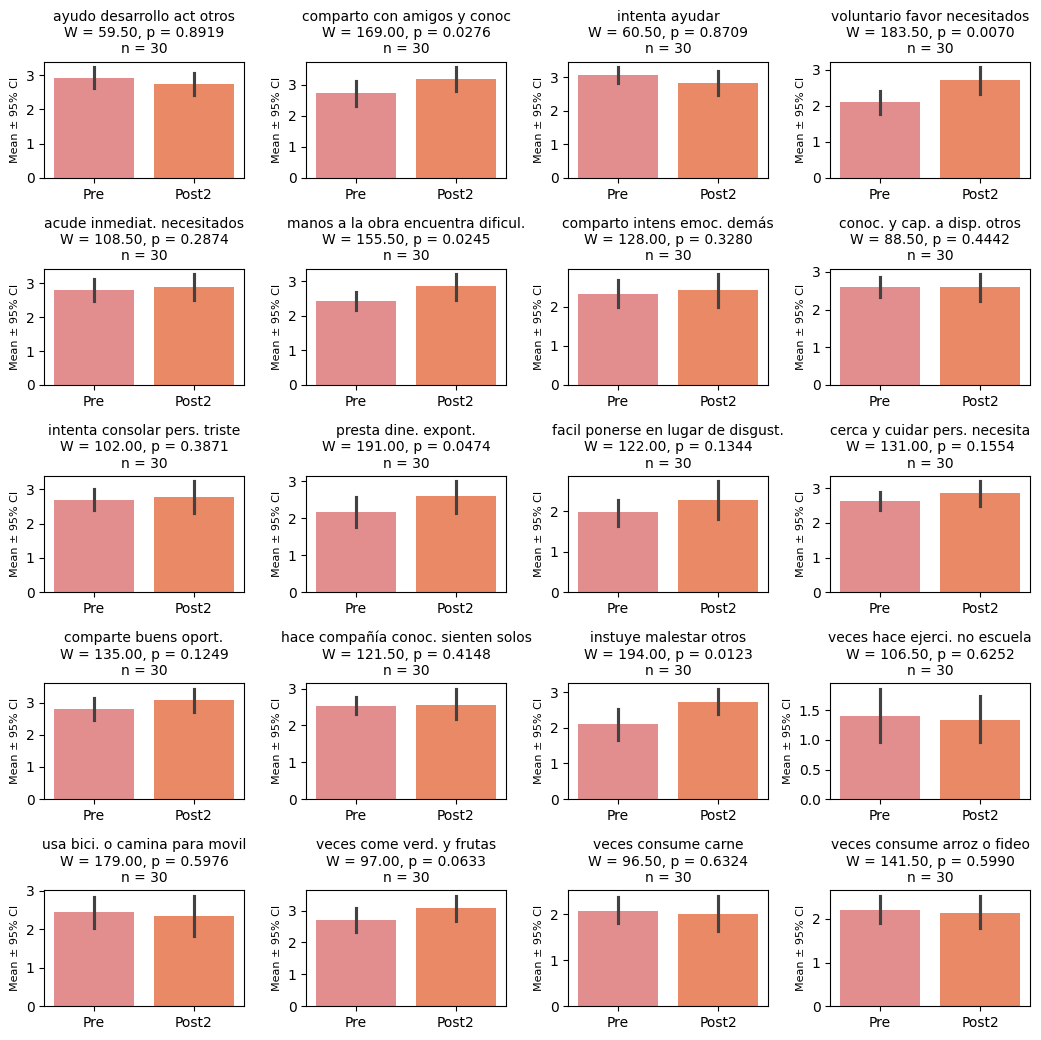

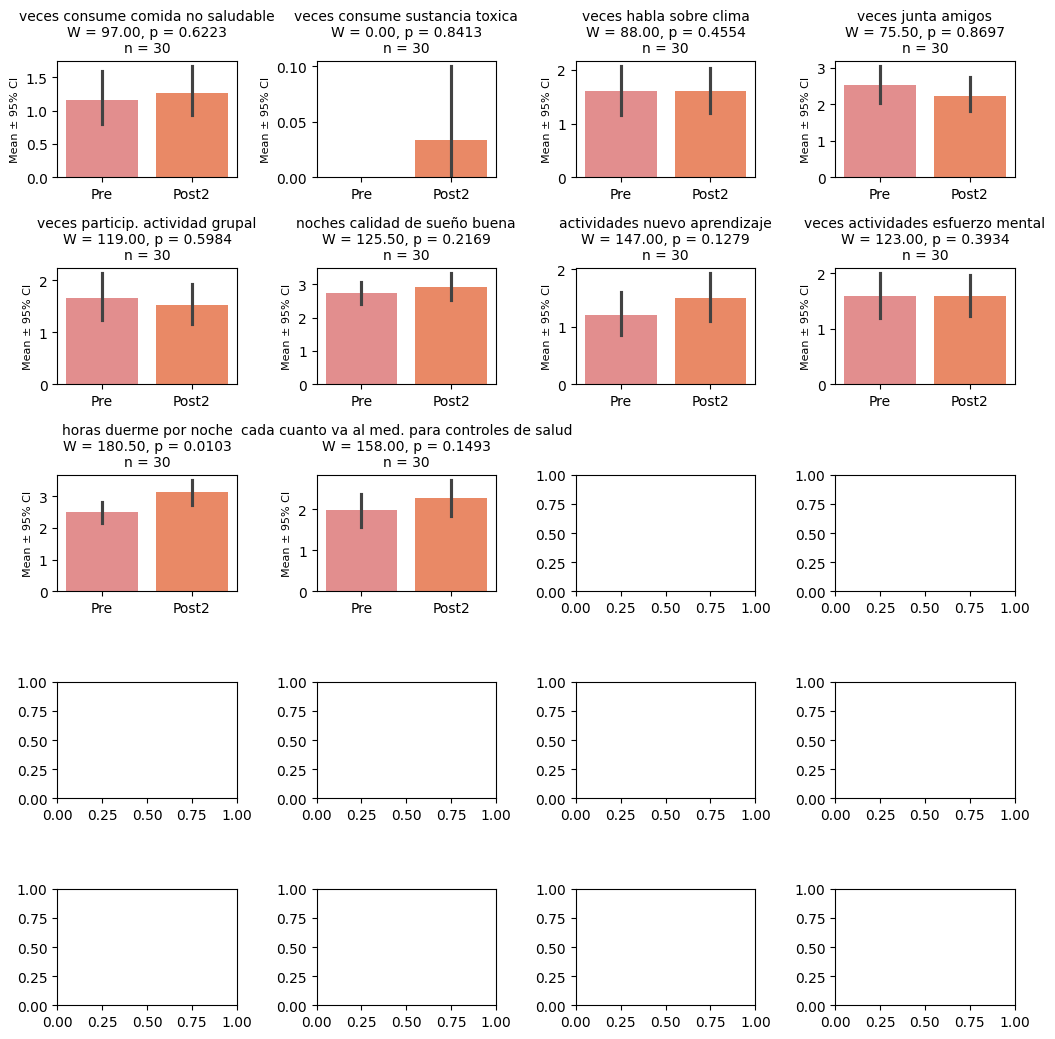

,Column,W,pvalue
1,comparto con amigos y conoc,169.0,0.027649
3,voluntario favor necesitados,183.5,0.007022
5,manos a la obra encuentra dificul.,155.5,0.024505
9,presta dine. expont.,191.0,0.047402
14,instuye malestar otros,194.0,0.012324


,Column,W,pvalue
8,horas duerme por noche,180.5,0.010257


In [5]:
out = run_wilcoxon_barplots(
    joined_df=df_data,
    cols_=cols_,
    pdf_path_part1=None,
    pdf_path_part2=None,
)

df = out["results_part1"]
display(df[df['pvalue']<0.05])

df = out["results_part2"]
display(df[df['pvalue']<0.05])